In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble  import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import random

from sklearn import metrics
from collections import Counter
import argparse
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import ParameterGrid
import lightgbm as lgb
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

In [2]:
data = pd.read_csv("dapps_with_features_v3.csv")

In [3]:
RS = 42
SPLITS = 5

In [4]:
X = data.drop('category', axis=1)
y = data.category

In [5]:
X, X_test, y, y_test  = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RS)

In [6]:
print(f'X_train shape {X.shape}')
print(f'X_test shape {X_test.shape}')

X_train shape (1716, 17)
X_test shape (430, 17)


# Training on code (no comments)

## Check for possible meta-parameters

In [8]:
length_SC = X.SC_no_comments.apply(lambda x: len(x.split()))

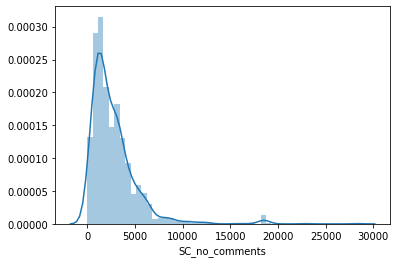

In [9]:
sns.distplot(length_SC)

In [10]:
length_SC.describe()

count     1716.000000
mean      2761.111888
std       2605.391686
min          5.000000
25%       1173.750000
50%       2070.000000
75%       3420.000000
max      28391.000000
Name: SC_no_comments, dtype: float64

In [11]:
X.SC_no_comments.str.split(expand=True).stack().value_counts()

newline                                    2137095
}                                           125672
=                                           123624
{                                           120403
function                                     92859
                                            ...   
onlyOwner()\n                                    1
"Source                                          1
BankerFarmer{                                    1
landSectorToWithdrawnAmount[landSector]          1
adminAddress,                                    1
Length: 160755, dtype: int64

### Ridge

In [12]:
kf  = StratifiedKFold(n_splits=SPLITS, random_state=RS)

word_vectorizer   = TfidfVectorizer(
    sublinear_tf  = True,
    strip_accents = 'unicode',
    analyzer      = 'word',
    token_pattern = r'\w{1,}',
    #stop_words    = 'english',
    ngram_range   = (1, 1),
    max_features  = 40000) # max 144018

/home/RDC/zinovyee.hub/anaconda3/envs/dmc/lib/python3.8/site-packages/sklearn/model_selection/_split.py:292: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [13]:
c = 0
C_parameter = np.arange(0.1, 1.1, 0.1) 

# use best C

C_parameter = [1]

In [14]:
names = [f'aucroc_{i}' for i in ['development', 'exchanges', 'finance', 'gambling', 'games',
       'high-risk', 'marketplaces', 'media', 'other', 'social']]
names2 = [f'aucprc_{i}' for i in ['development', 'exchanges', 'finance', 'gambling', 'games',
       'high-risk', 'marketplaces', 'media', 'other', 'social']]
names.extend(names2)

In [15]:
for c_p in C_parameter:  
    metrics_cv = pd.DataFrame(np.zeros((SPLITS, len(names))), columns=names)
    for c, (train_index, val_index) in enumerate(kf.split(X, y)):

            X_train, X_val      = X.iloc[train_index]['comments'], X.iloc[val_index]['comments']
            y_train, y_val      = y.iloc[train_index], y.iloc[val_index] 
            word_vectorizer.fit(X_train)
            train_word_features = word_vectorizer.transform(X_train)
            val_word_features   = word_vectorizer.transform(X_val)
             
            le = LabelBinarizer()
            le.fit(y_train)
            
            y_train = le.transform(y_train)
            y_val = le.transform(y_val)
            
            for i, cl in enumerate(le.classes_):
                classifier = LogisticRegression(C=c_p, solver='sag', random_state=RS)
                classifier.fit(train_word_features, y_train[:,i])
                probs      = classifier.predict_proba(val_word_features)[:,1]
                auc_roc_class = roc_auc_score(y_val[:,i], probs)
                auc_pr_class = average_precision_score(y_val[:,i], probs)
                
                metrics_cv.loc[c, f'aucroc_{cl}'] = round(auc_roc_class, 3)
                metrics_cv.loc[c, f'aucprc_{cl}'] = round(auc_pr_class, 3)   
                
    print(f"C:{c_p} AUC ROC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0).mean(), 3)}")
    print(f"C:{c_p} AUC PRC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0).mean(), 3)}")

C:1 AUC ROC: 0.887
C:1 AUC PRC: 0.578


In [16]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0), 3)

aucroc_development     0.842
aucroc_exchanges       0.959
aucroc_finance         0.917
aucroc_gambling        0.909
aucroc_games           0.925
aucroc_high-risk       0.948
aucroc_marketplaces    0.874
aucroc_media           0.846
aucroc_other           0.850
aucroc_social          0.802
dtype: float64

In [17]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0), 3)

aucprc_development     0.421
aucprc_exchanges       0.937
aucprc_finance         0.802
aucprc_gambling        0.722
aucprc_games           0.826
aucprc_high-risk       0.677
aucprc_marketplaces    0.569
aucprc_media           0.221
aucprc_other           0.447
aucprc_social          0.156
dtype: float64

In [18]:
metrics_cv

,aucroc_development,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucroc_marketplaces,aucroc_media,aucroc_other,aucroc_social,aucprc_development,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk,aucprc_marketplaces,aucprc_media,aucprc_other,aucprc_social
0,0.815,0.959,0.885,0.901,0.926,0.939,0.889,0.850,0.831,0.798,0.288,0.936,0.733,0.785,0.855,0.576,0.556,0.210,0.416,0.134
1,0.840,0.971,0.925,0.898,0.908,0.951,0.839,0.844,0.806,0.730,0.478,0.950,0.833,0.622,0.771,0.660,0.616,0.319,0.370,0.089
2,0.916,0.965,0.925,0.902,0.928,0.931,0.832,0.843,0.858,0.846,0.454,0.943,0.808,0.718,0.841,0.743,0.449,0.206,0.512,0.216
3,0.894,0.977,0.961,0.904,0.943,0.966,0.922,0.874,0.873,0.797,0.525,0.964,0.883,0.722,0.851,0.647,0.662,0.190,0.480,0.163
4,0.743,0.923,0.890,0.942,0.920,0.953,0.887,0.817,0.884,0.840,0.358,0.893,0.754,0.762,0.814,0.761,0.564,0.181,0.455,0.180


In [19]:
# TRAIN ON WHOLE DATA AND PREDICT ON TEST
metrics = pd.DataFrame(np.zeros((1,len(names))), columns=names)
word_vectorizer.fit(X['comments'])
train_word_features  = word_vectorizer.transform(X['comments'])
test_word_features   = word_vectorizer.transform(X_test['comments'])

le = LabelBinarizer()
le.fit(y)

y_train = le.transform(y)
y_test_lb = le.transform(y_test)

for i, cl in enumerate(le.classes_):
    classifier = LogisticRegression(C=c_p, solver='sag', random_state=RS)
    classifier.fit(train_word_features, y_train[:,i])
    probs      = classifier.predict_proba(test_word_features)[:,1]
    auc_roc_class = roc_auc_score(y_test_lb[:,i], probs)
    auc_pr_class = average_precision_score(y_test_lb[:,i], probs)

    metrics.loc[0, f'aucroc_{cl}'] = round(auc_roc_class, 3)
    metrics.loc[0, f'aucprc_{cl}'] = round(auc_pr_class, 3)   

In [20]:
metrics

,aucroc_development,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucroc_marketplaces,aucroc_media,aucroc_other,aucroc_social,aucprc_development,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk,aucprc_marketplaces,aucprc_media,aucprc_other,aucprc_social
0,0.892,0.95,0.924,0.904,0.931,0.95,0.878,0.898,0.949,0.69,0.393,0.924,0.779,0.645,0.835,0.623,0.628,0.271,0.58,0.072


In [21]:
round(metrics.loc[:, metrics.columns.str.contains('aucroc')].mean(axis=1), 3)

0    0.897
dtype: float64

In [22]:
round(metrics.loc[:, metrics.columns.str.contains('aucprc')].mean(axis=1), 3)

0    0.575
dtype: float64

### Random Forest

In [23]:
kf  = StratifiedKFold(n_splits=SPLITS, random_state=RS)

word_vectorizer   = TfidfVectorizer(
    sublinear_tf  = True,
    strip_accents = 'unicode',
    analyzer      = 'word',
    token_pattern = r'\w{1,}',
    ngram_range   = (1, 1),
    max_features  = 40000) # max 144018

/home/RDC/zinovyee.hub/anaconda3/envs/dmc/lib/python3.8/site-packages/sklearn/model_selection/_split.py:292: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [24]:
metrics_cv = pd.DataFrame(np.zeros((SPLITS, len(names))), columns=names)
for c, (train_index, val_index) in enumerate(kf.split(X, y)):

        X_train, X_val      = X.iloc[train_index]['comments'], X.iloc[val_index]['comments']
        y_train, y_val      = y.iloc[train_index], y.iloc[val_index] 
        word_vectorizer.fit(X_train)
        train_word_features = word_vectorizer.transform(X_train)
        val_word_features   = word_vectorizer.transform(X_val)

        le = LabelBinarizer()
        le.fit(y_train)

        y_train = le.transform(y_train)
        y_val = le.transform(y_val)

        
        classifier          = RandomForestClassifier(n_estimators=600, max_depth=None, max_features='auto', 
                            min_samples_split=2, verbose = True, n_jobs=20, random_state=RS)
        classifier.fit(train_word_features, y_train)
        probs = classifier.predict_proba(val_word_features)
        
        for i, cl in enumerate(le.classes_):
            auc_roc_class = roc_auc_score(y_val[:,i], probs[i][:,1])
            auc_pr_class = average_precision_score(y_val[:,i], probs[i][:,1])

            metrics_cv.loc[c, f'aucroc_{cl}'] = round(auc_roc_class, 3)
            metrics_cv.loc[c, f'aucprc_{cl}'] = round(auc_pr_class, 3)   

print(f"C:{c_p} AUC ROC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0).mean(), 3)}")
print(f"C:{c_p} AUC PRC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0).mean(), 3)}")

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    1.1s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    2.7s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    3.8s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    0.8s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    1.1s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    2.7s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed: 

C:1 AUC ROC: 0.888
C:1 AUC PRC: 0.581


[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    0.8s finished


In [25]:
metrics_cv

,aucroc_development,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucroc_marketplaces,aucroc_media,aucroc_other,aucroc_social,aucprc_development,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk,aucprc_marketplaces,aucprc_media,aucprc_other,aucprc_social
0,0.901,0.964,0.899,0.919,0.915,0.946,0.903,0.846,0.836,0.801,0.337,0.942,0.757,0.801,0.842,0.610,0.579,0.206,0.407,0.289
1,0.821,0.983,0.934,0.895,0.892,0.908,0.861,0.839,0.796,0.719,0.283,0.958,0.829,0.572,0.780,0.551,0.591,0.310,0.356,0.070
2,0.911,0.970,0.949,0.912,0.932,0.949,0.904,0.860,0.866,0.882,0.478,0.940,0.865,0.692,0.861,0.723,0.526,0.261,0.505,0.283
3,0.890,0.976,0.954,0.910,0.949,0.948,0.947,0.774,0.885,0.835,0.518,0.957,0.875,0.725,0.885,0.630,0.618,0.126,0.478,0.218
4,0.684,0.940,0.883,0.955,0.924,0.929,0.822,0.824,0.878,0.800,0.382,0.897,0.742,0.761,0.828,0.642,0.579,0.374,0.483,0.137


In [26]:
# TRAIN ON WHOLE DATA AND PREDICT ON TEST
metrics = pd.DataFrame(np.zeros((1,len(names))), columns=names)
word_vectorizer.fit(X['comments'])
train_word_features  = word_vectorizer.transform(X['comments'])
test_word_features   = word_vectorizer.transform(X_test['comments'])

le = LabelBinarizer()
le.fit(y)

y_train = le.transform(y)
y_test_lb = le.transform(y_test)


classifier = RandomForestClassifier(n_estimators=600, max_depth=None, max_features='auto', 
                            min_samples_split=2, verbose = True, n_jobs=20, random_state=RS)
classifier.fit(train_word_features, y_train)
probs      = classifier.predict_proba(test_word_features)

for i, cl in enumerate(le.classes_):
    auc_roc_class = roc_auc_score(y_test_lb[:,i], probs[i][:,1])
    auc_pr_class = average_precision_score(y_test_lb[:,i], probs[i][:,1])

    metrics.loc[0, f'aucroc_{cl}'] = round(auc_roc_class, 3)
    metrics.loc[0, f'aucprc_{cl}'] = round(auc_pr_class, 3)   

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    1.2s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    3.0s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    4.3s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    0.8s finished


In [27]:
metrics

,aucroc_development,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucroc_marketplaces,aucroc_media,aucroc_other,aucroc_social,aucprc_development,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk,aucprc_marketplaces,aucprc_media,aucprc_other,aucprc_social
0,0.956,0.969,0.939,0.892,0.939,0.959,0.929,0.916,0.934,0.778,0.401,0.946,0.81,0.659,0.88,0.663,0.683,0.492,0.596,0.195


In [28]:
round(metrics.loc[:, metrics.columns.str.contains('aucroc')].mean(axis=1), 3)

0    0.921
dtype: float64

In [29]:
round(metrics.loc[:, metrics.columns.str.contains('aucprc')].mean(axis=1), 3)

0    0.633
dtype: float64

### SVM

In [30]:
penalty = ['l2', 'l1']
alpha = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
max_iter = [1000, 10000, 15000]

# best parameters
penalty = ['l1']
alpha = [0.00001]
max_iter = [1000] 

for p in penalty:
  for a in alpha:
    for it in max_iter:
      auc = []
      roc = []
      fscore_ = []
      c = 0
      # print performance
      print(f'-------------')
      print(f'penalty {p}')
      print(f'alpha {a}')
      print(f'max_iter {i}')
      print(f'-------------')
      
    
      metrics_cv = pd.DataFrame(np.zeros((SPLITS, len(names))), columns=names)
      for c, (train_index, val_index) in enumerate(kf.split(X, y)):

            X_train, X_val      = X.iloc[train_index]['comments'], X.iloc[val_index]['comments']
            y_train, y_val      = y.iloc[train_index], y.iloc[val_index] 
            word_vectorizer.fit(X_train)
            train_word_features = word_vectorizer.transform(X_train)
            val_word_features   = word_vectorizer.transform(X_val)
             
            le = LabelBinarizer()
            le.fit(y_train)
            
            y_train = le.transform(y_train)
            y_val = le.transform(y_val)
            
            for i, cl in enumerate(le.classes_):
                classifier = SGDClassifier(n_jobs=20, random_state=RS, loss='log', shuffle=False, 
                                    penalty=p, alpha=a, max_iter=it)
                classifier.fit(train_word_features, y_train[:,i])
                probs      = classifier.predict_proba(val_word_features)[:,1]
                auc_roc_class = roc_auc_score(y_val[:,i], probs)
                auc_pr_class = average_precision_score(y_val[:,i], probs)
                
                metrics_cv.loc[c, f'aucroc_{cl}'] = round(auc_roc_class, 3)
                metrics_cv.loc[c, f'aucprc_{cl}'] = round(auc_pr_class, 3)   
                
    print(f"C:{c_p} AUC ROC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0).mean(), 3)}")
    print(f"C:{c_p} AUC PRC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0).mean(), 3)}")

-------------
penalty l1
alpha 1e-05
max_iter 9
-------------
C:1 AUC ROC: 0.878
C:1 AUC PRC: 0.609


In [31]:
metrics_cv

,aucroc_development,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucroc_marketplaces,aucroc_media,aucroc_other,aucroc_social,aucprc_development,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk,aucprc_marketplaces,aucprc_media,aucprc_other,aucprc_social
0,0.850,0.953,0.877,0.896,0.940,0.914,0.824,0.874,0.887,0.826,0.311,0.931,0.750,0.756,0.848,0.552,0.606,0.437,0.566,0.201
1,0.688,0.962,0.920,0.886,0.897,0.937,0.897,0.906,0.802,0.660,0.397,0.947,0.821,0.585,0.766,0.696,0.680,0.382,0.381,0.112
2,0.721,0.956,0.920,0.907,0.917,0.934,0.831,0.800,0.836,0.861,0.360,0.932,0.811,0.719,0.834,0.714,0.459,0.303,0.549,0.333
3,0.929,0.970,0.960,0.943,0.956,0.955,0.939,0.805,0.831,0.855,0.617,0.966,0.877,0.781,0.888,0.695,0.763,0.177,0.479,0.235
4,0.713,0.932,0.898,0.945,0.934,0.921,0.849,0.788,0.859,0.846,0.437,0.912,0.772,0.800,0.859,0.676,0.628,0.445,0.497,0.190


In [32]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0), 3)

aucroc_development     0.780
aucroc_exchanges       0.955
aucroc_finance         0.915
aucroc_gambling        0.915
aucroc_games           0.929
aucroc_high-risk       0.932
aucroc_marketplaces    0.868
aucroc_media           0.835
aucroc_other           0.843
aucroc_social          0.810
dtype: float64

In [33]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0), 3)

aucprc_development     0.424
aucprc_exchanges       0.938
aucprc_finance         0.806
aucprc_gambling        0.728
aucprc_games           0.839
aucprc_high-risk       0.667
aucprc_marketplaces    0.627
aucprc_media           0.349
aucprc_other           0.494
aucprc_social          0.214
dtype: float64

In [34]:
# TRAIN ON WHOLE DATA AND PREDICT ON TEST
metrics = pd.DataFrame(np.zeros((1,len(names))), columns=names)
word_vectorizer.fit(X['comments'])
train_word_features  = word_vectorizer.transform(X['comments'])
test_word_features   = word_vectorizer.transform(X_test['comments'])

le = LabelBinarizer()
le.fit(y)

y_train = le.transform(y)
y_test_lb = le.transform(y_test)

for i, cl in enumerate(le.classes_):
    classifier = SGDClassifier(n_jobs=20, random_state=RS, loss='log', shuffle=False, 
                                    penalty=penalty[0], alpha=alpha[0], max_iter=max_iter[0])
    classifier.fit(train_word_features, y_train[:,i])
    probs      = classifier.predict_proba(test_word_features)[:,1]
    auc_roc_class = roc_auc_score(y_test_lb[:,i], probs)
    auc_pr_class = average_precision_score(y_test_lb[:,i], probs)

    metrics.loc[0, f'aucroc_{cl}'] = round(auc_roc_class, 3)
    metrics.loc[0, f'aucprc_{cl}'] = round(auc_pr_class, 3)   

In [35]:
metrics

,aucroc_development,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucroc_marketplaces,aucroc_media,aucroc_other,aucroc_social,aucprc_development,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk,aucprc_marketplaces,aucprc_media,aucprc_other,aucprc_social
0,0.86,0.984,0.923,0.881,0.945,0.965,0.927,0.872,0.92,0.681,0.306,0.959,0.808,0.688,0.905,0.708,0.741,0.497,0.671,0.204
